In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
file_path = '/content/morning cluster.sx.xlsx'  # Update this with your actual file path
data = pd.read_excel(file_path)

In [3]:
data['Load_Lag_1'] = data['POWER (KW)'].shift(1)     # Previous hour
data['Load_Lag_24'] = data['POWER (KW)'].shift(24)   # Previous day
data['Load_Lag_168'] = data['POWER (KW)'].shift(168) # Previous week

# Create lagged features for seasonal parameters (example: Temperature and Humidity)
data['Temp_Lag_1'] = data['Temp (F)'].shift(1)
data['Temp_Lag_24'] = data['Temp (F)'].shift(24)
data['Humidity_Lag_1'] = data['Humidity (%)'].shift(1)
data['Humidity_Lag_24'] = data['Humidity (%)'].shift(24)

In [4]:
data.dropna(inplace=True)

In [5]:
X = data[['Load_Lag_1','Load_Lag_24','Load_Lag_168','Temp_Lag_1','"WEEKEND/WEEKDAY"','SEASON','Temp_Lag_24','Humidity_Lag_1','Humidity_Lag_24']]
y = data['POWER (KW)']

In [6]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [8]:
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [9]:
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

In [10]:
param_grid = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10, 100]},
    {'kernel': ['poly'], 'C': [0.1, 1, 10], 'degree': [2, 3, 4], 'gamma': ['scale', 'auto'], 'coef0': [0, 1]},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1, 0.01]},
    {'kernel': ['sigmoid'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'coef0': [0, 1]}
]

# Initialize the SVR model
svr = SVR()


In [11]:
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train_scaled, y_train_scaled)

# Get the best estimator
best_svr = grid_search.best_estimator_

In [12]:
y_pred_train_scaled = best_svr.predict(X_train_scaled)
y_pred_test_scaled = best_svr.predict(X_test_scaled)

In [ ]:
results = pd.DataFrame({'Actual': y_test_scaled, 'Predicted':y_pred_test_scaled})
print(results.head())

     Actual  Predicted
0  0.087892   0.096450
1  0.070667   0.303582
2  0.027036   0.047043
3  0.124088   0.138356
4  0.327932   0.295787


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
mse_test = mean_squared_error(y_test_scaled,y_pred_test_scaled )
r2_test = r2_score(y_test_scaled,y_pred_test_scaled)
mae_test = mean_absolute_error(y_test_scaled, y_pred_test_scaled)
mpe_test = np.mean(np.abs((y_test_scaled - y_pred_test_scaled) / y_test)) * 100
print(f'Testing MSE: {mse_test}')
print(f'Testing R²: {r2_test}')
print(f'Testing MAE: {mae_test}')
print(f'Testing MPE: {mpe_test}')

Testing MSE: 0.008285966087154097
Testing R²: 0.8437671810288457
Testing MAE: 0.0641042489231196
Testing MPE: 0.0044276360201737945


In [ ]:
from math import sqrt # Import the sqrt function from the math module

rsme = sqrt(mse_test)
print(rsme)

0.09102728210352157


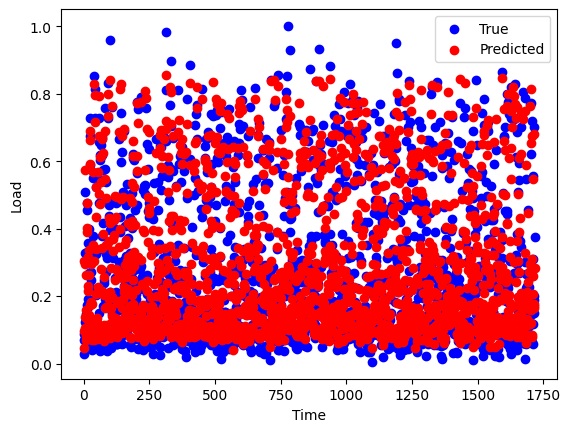

In [ ]:
plt.scatter(range(len(y_test_scaled)), y_test_scaled, color='blue', label='True')
plt.scatter(range(len(y_pred_test_scaled)), y_pred_test_scaled, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.show()

In [ ]:
import pandas as pd

# Assuming X_test, y_test, and y_pred are already defined
# Convert X_test[:, 0] to datetime if needed


# Create a DataFrame
data = {

    'Actual Values': y_test_scaled,
    'Predicted Values': y_pred_test_scaled
}
df = pd.DataFrame(data)

# Save the DataFrame to an Excel file
excel_filename = '/content/svrshift.xlsx'
df.to_excel(excel_filename, index=False)

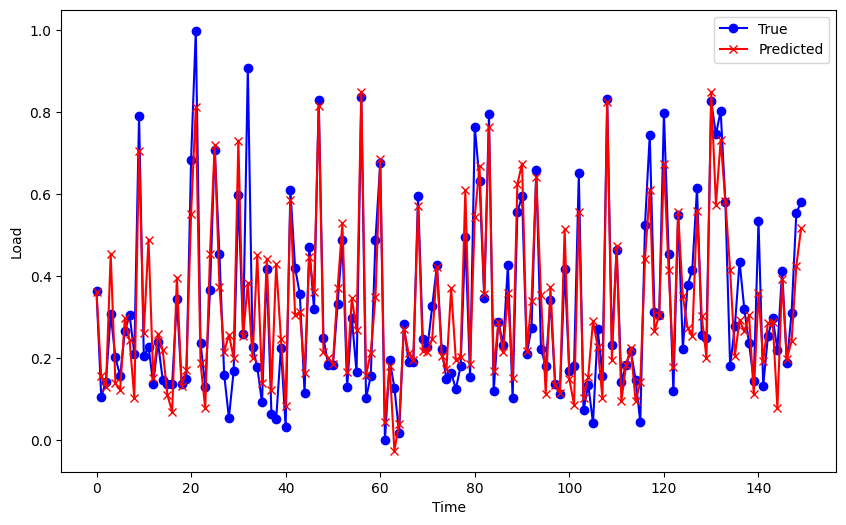

In [13]:
import matplotlib.pyplot as plt

# Define the number of points to display
num_points = 150

# Ensure we only take the first 150 points
y_test_subset = y_test_scaled[:num_points]
predictions_subset = y_pred_test_scaled[:num_points]

plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test_subset)), y_test_subset, color='blue', marker='o', linestyle='-', label='True')
plt.plot(range(len(predictions_subset)), predictions_subset, color='red', marker='x', linestyle='-', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.show()